In [8]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits import mplot3d

## 1 决策树桩+AdaBoost 

In [9]:
x = np.array([[0,1,3],
             [0,3,1],
             [1,2,2],
             [1,1,3],
             [1,2,3],
             [0,1,2],
             [1,1,2],
             [1,1,1],
             [1,3,1],
             [0,2,1]])
y = np.array([-1,-1,-1,-1,-1,-1,1,1,-1,-1])
print(x.shape,y.shape)

(10, 3) (10,)


In [10]:
dataMatrix = np.matrix(x)
print(dataMatrix)
labelMatrix = np.matrix([-1,-1,-1,-1,-1,-1,1,1,-1,-1]).T
print(labelMatrix)


[[0 1 3]
 [0 3 1]
 [1 2 2]
 [1 1 3]
 [1 2 3]
 [0 1 2]
 [1 1 2]
 [1 1 1]
 [1 3 1]
 [0 2 1]]
[[-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [ 1]
 [ 1]
 [-1]
 [-1]]


In [15]:
def showDataSet(dataMatrix,labelMatrix):
    ax = plt.axes(projection='3d')
    data_pos = []
    data_neg = []
    for i in range(len(dataMatrix)):
        if labelMatrix[i] >0:
            data_pos.append(dataMatrix[i])
        else:
            data_neg.append(dataMatrix[i])
    data_pos_np = np.array(data_pos).T
    data_neg_np = np.array(data_neg).T
    ax.scatter(data_pos_np[0],data_pos_np[1],data_pos_np[2],c='orange',marker='*')
    ax.scatter(data_neg_np[0],data_neg_np[1],data_neg_np[2],c='purple',marker='*')
    plt.show()

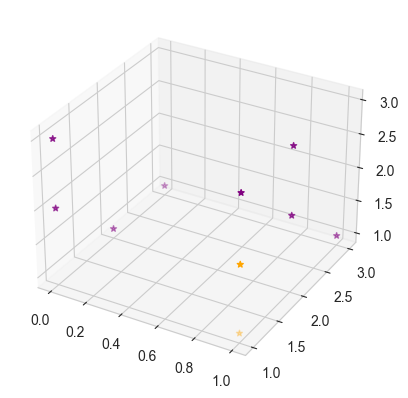

In [16]:
showDataSet(dataMatrix,labelMatrix)

In [6]:

def stumpClassify(dataMatrix,dim,threshold,threshInequal):
    # 分类函数，通过阈值threshold对数据进行分类
    returnArray = np.ones((np.shape(dataMatrix)[0],1)) # 初始化
    # 小于：lt less than；大于gt  greater than
    if threshInequal == 'lt':
        returnArray[dataMatrix[:,dim]<=threshold] = -1.0
    else:
        returnArray[dataMatrix[:,dim]>threshold] = -1.0
    return returnArray

def buildStump(dataMatrix,classLabels,D):
    # 构建当前数据集的最佳决策树，遍历不同的阈值且计算分类误差， 找到分类误差最小的单层决策树   
    # D:样本权重
    m,n = np.shape(dataMatrix)
    numSteps = 50.0 # 步长
    bestStumpInfo = {} # 最佳单层决策树的信息
    bestClassEst = np.mat(np.zeros((m,1))) # 最佳的分类结果
    minErr = float('inf') # 最小的误差
    for i in range(n):
        # 计算当前第i个特征的最大和最小值
        stepSize = (dataMatrix[:,i].max() - dataMatrix[:,i].min())/numSteps
        for j in range(-1,int(numSteps)+1):
            for inequalType in ['lt','gt']:
                threshold = (dataMatrix[:,i].min() + stepSize*float(j))
                predictVals = stumpClassify(dataMatrix,i,threshold,inequalType)
                # 计算误差，初始化误差矩阵
                errMatrix = np.matrix(np.ones((m,1)))
                errMatrix[classLabels== predictVals] = 0
                weightedErr = np.mean(D.T * errMatrix)
                # print(i,threshhold,inequal,weighted_err)
                print(f'SPLIT[{j}]:dim {i}, threshold {threshold:.2f}, inequalType {inequalType}, weighted error {weightedErr:.3f}')
                if weightedErr < minErr:
                    minErr = weightedErr
                    bestClassEst = predictVals.copy()
                    bestStumpInfo['dim'] = i
                    bestStumpInfo['thresh'] = threshold
                    bestStumpInfo['ineq'] = inequalType
    return bestStumpInfo,minErr,bestClassEst

In [8]:
# 计算权重
D = np.matrix(np.ones((dataMatrix.shape[0],1))/dataMatrix.shape[0])

bestStumpInfo,minErr,bestClassEst = buildStump(dataMatrix,labelMatrix,D)
print(f'bestStumpInfo {bestStumpInfo}')
print(f'minErr {minErr}')
print(f'bestClassEst {bestClassEst.T}')
print(f'labelMatrix {labelMatrix.T}')


SPLIT[-1]:dim 0, threshold -0.02, inequalType lt, weighted error 0.800
SPLIT[-1]:dim 0, threshold -0.02, inequalType gt, weighted error 0.200
SPLIT[0]:dim 0, threshold 0.00, inequalType lt, weighted error 0.400
SPLIT[0]:dim 0, threshold 0.00, inequalType gt, weighted error 0.600
SPLIT[1]:dim 0, threshold 0.02, inequalType lt, weighted error 0.400
SPLIT[1]:dim 0, threshold 0.02, inequalType gt, weighted error 0.600
SPLIT[2]:dim 0, threshold 0.04, inequalType lt, weighted error 0.400
SPLIT[2]:dim 0, threshold 0.04, inequalType gt, weighted error 0.600
SPLIT[3]:dim 0, threshold 0.06, inequalType lt, weighted error 0.400
SPLIT[3]:dim 0, threshold 0.06, inequalType gt, weighted error 0.600
SPLIT[4]:dim 0, threshold 0.08, inequalType lt, weighted error 0.400
SPLIT[4]:dim 0, threshold 0.08, inequalType gt, weighted error 0.600
SPLIT[5]:dim 0, threshold 0.10, inequalType lt, weighted error 0.400
SPLIT[5]:dim 0, threshold 0.10, inequalType gt, weighted error 0.600
SPLIT[6]:dim 0, threshold 0.12

In [15]:
def adaBoostDSTrain(dataMatrix,classLabels,tol = 0.05,iter_max = 40):
    weakClassArray = []
    m = np.shape(dataMatrix)[0]
    D = np.matrix(np.ones((m,1))/m) # 初始化权重
    aggClassEst = np.mat(np.zeros((m,1))) # 初始化估计值
    for i in range(iter_max):
        bestStumpi,erri,classEsti = buildStump(dataMatrix,classLabels,D)
        print(f'D {D.T}',end=',')
        alpha = float(0.5*np.log((1.0-erri)/max(erri,1e-15))) # 避免分母为0
        bestStumpi['alpha'] = alpha # alpha：弱分类器权重
        weakClassArray.append(bestStumpi) #存储弱分类器
        print(f'classEsti {classEsti.T}',end=',')
        expon = np.multiply(-1*alpha*labelMatrix,classEsti) # 指数
        D = np.multiply(D,np.exp(expon))
        D = D/D.sum() # 更新样本权重，除以规范化因子
        aggClassEst += alpha*classEsti
        print(f'aggClassEsti {aggClassEst}',end=',')
        # 计算误差
        aggErr = np.multiply(np.sign(aggClassEst)!=labelMatrix,np.ones((m,1)))
        errRate = aggErr.sum()/m
        print(f'total error {errRate:.3f}')
        # 直到误差为0
        if errRate == 0:
            break
    return weakClassArray,aggClassEst

        

In [16]:
weakClassArray,aggClassEst = adaBoostDSTrain(dataMatrix,labelMatrix)
print(f'weakClassArray {weakClassArray}')
print(f'aggClassEst {aggClassEst}')

SPLIT[-1]:dim 0, threshold -0.02, inequalType lt, weighted error 0.800
SPLIT[-1]:dim 0, threshold -0.02, inequalType gt, weighted error 0.200
SPLIT[0]:dim 0, threshold 0.00, inequalType lt, weighted error 0.400
SPLIT[0]:dim 0, threshold 0.00, inequalType gt, weighted error 0.600
SPLIT[1]:dim 0, threshold 0.02, inequalType lt, weighted error 0.400
SPLIT[1]:dim 0, threshold 0.02, inequalType gt, weighted error 0.600
SPLIT[2]:dim 0, threshold 0.04, inequalType lt, weighted error 0.400
SPLIT[2]:dim 0, threshold 0.04, inequalType gt, weighted error 0.600
SPLIT[3]:dim 0, threshold 0.06, inequalType lt, weighted error 0.400
SPLIT[3]:dim 0, threshold 0.06, inequalType gt, weighted error 0.600
SPLIT[4]:dim 0, threshold 0.08, inequalType lt, weighted error 0.400
SPLIT[4]:dim 0, threshold 0.08, inequalType gt, weighted error 0.600
SPLIT[5]:dim 0, threshold 0.10, inequalType lt, weighted error 0.400
SPLIT[5]:dim 0, threshold 0.10, inequalType gt, weighted error 0.600
SPLIT[6]:dim 0, threshold 0.12

In [24]:
def adaBoostDSClassify(dataMatrix,classifierArray):
    m = dataMatrix.shape[0]
    aggClassEst = np.matrix(np.zeros((m,1)))# 初始化估计值
    # 遍历分类器
    for i in range(len(classifierArray)):
        classEsti = stumpClassify(dataMatrix,classifierArray[i]['dim'],classifierArray[i]['thresh'],classifierArray[i]['ineq'])
        aggClassEst += classifierArray[i]['alpha']*classEsti
        print(f'aggClassEst {aggClassEst.T}')
    return np.sign(aggClassEst)

In [25]:
def cal_error(labelMatrix,predLabelMatrix):
    err = 0
    n = labelMatrix.shape[0]
    for i in range(n):
        if labelMatrix[i] != predLabelMatrix[i]:
            err += 1
    return err/n
    

In [27]:
aggClassEstAdaDS = adaBoostDSClassify(dataMatrix,weakClassArray)
print(f'aggClassEstAdaDS {aggClassEstAdaDS.T}')
print(f'lableMatrix {labelMatrix.T}')
print(f'error {cal_error(labelMatrix,aggClassEstAdaDS)}')


aggClassEst [[-0.69314718 -0.69314718 -0.69314718 -0.69314718 -0.69314718 -0.69314718
  -0.69314718 -0.69314718 -0.69314718 -0.69314718]]
aggClassEst [[ 0.04002135 -1.42631571 -1.42631571  0.04002135 -1.42631571  0.04002135
   0.04002135  0.04002135 -1.42631571 -1.42631571]]
aggClassEst [[-0.45924306 -0.9270513  -1.92558013 -0.45924306 -1.92558013 -0.45924306
  -0.45924306  0.53928577 -0.9270513  -0.9270513 ]]
aggClassEst [[-1.04081847 -1.5086267  -1.34400473  0.12233234 -1.34400473 -1.04081847
   0.12233234  1.12086117 -0.34547589 -1.5086267 ]]
aggClassEst [[-1.57273155 -2.04053979 -1.87591781 -0.40958074 -1.87591781 -1.57273155
  -0.40958074  0.58894809 -0.87738898 -2.04053979]]
aggClassEst [[-2.11821021 -1.49506113 -1.33043916 -0.9550594  -2.42139647 -1.0272529
   0.13589791  1.13442674 -0.33191033 -1.49506113]]
aggClassEstAdaDS [[-1. -1. -1. -1. -1. -1.  1.  1. -1. -1.]]
lableMatrix [[-1 -1 -1 -1 -1 -1  1  1 -1 -1]]
error 0.0


## 2 Adaboost&SVM&Logistic Regression
比较支持向量机、AdaBoost、逻辑斯谛回归模型的学习策略与算法。
* 相似：把弱分类器看成SVM的核函数，**按照最大化某个最小间隔的方式**重写Adaboost算法
* 不同：两者定义的间隔计算方式不同，导致结果不同，高维度空间下二者的差异更加明显

In [18]:
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


In [19]:
# 在AdaBoost算法中使用SVM作为弱分类器，相当于让AdaBoost的弱分类器作为SVM的核函数
x1,y1 = datasets.make_classification(n_samples = 50,n_features=50,n_informative=20,random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size=0.3, random_state=42)
svm_1 = SVC(kernel='rbf',C = 0.6,gamma = 'scale')
ada_svm = AdaBoostClassifier(n_estimators=50,base_estimator=svm_1,algorithm = 'SAMME') 
ada_svm.fit(x_train,y_train)
y_pred = ada_svm.predict(x_test)
print(accuracy_score(y_test,y_pred))


0.4


### 把弱分类器看成SVM的核函数，**按照最大化某个最小间隔的方式**重写Adaboost算法
我们可以把弱分类器想象成 SVM 中的一个核函数，也可以按照最大化某个最小间隔的方式重写 AdaBoost 算法。而它们的不同就在于其所定义的间隔计算方式有所不同，因此导致的结果也不同。
* **弱分类器看作核函数**：我们把弱分类器的输出，看作一种核函数的输出，弱分类器的映射相当于核函数把数据映射到高维空间的映射。
* **最大化最小间隔**：在AdaBoost中，我们尝试模拟支持向量机寻找最优权重向量的方式来通过调整分类器的"权重"，实现最小间隔最大化
* 算法的重写思路
    * 初始化：样本权重初始化为均匀分布。
    * 迭代过程：
        * 对每个弱分类器，计算在这个权重分布下的错误率
        * 选择错误率最低的弱分类器，看作当前的最优“核函数”
        * 根据弱分类器的表现，调整样本的权重，让被错误分类样本的权重增加，正确分类样本的权重减少
        * 更新分类器权重，让新加入的弱分类器与性能成为正比


In [23]:
# 对高维度数据进行标准化和降维
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x1)
pca_1 = PCA(n_components=2)
x1_pca = pca_1.fit_transform(x_scaled)
x_train,x_test,y_train,y_test = train_test_split(x1_pca,y1,test_size=0.3,random_state=42)
# 实例化分类器
svm_2 = SVC(kernel='linear',C = 0.6)
svm_2.fit(x_train,y_train)

svm_k = SVC(kernel='rbf',C = 0.6,gamma = 'scale')
svm_k.fit(x_train,y_train)

ada_2 = AdaBoostClassifier(n_estimators=50)
ada_2.fit(x_train,y_train)

log_2= LogisticRegression()
log_2.fit(x_train,y_train)
    

LogisticRegression()

In [24]:
# 绘制决策边界示意图
colors = ('orange','blue')
cmap = ListedColormap(colors)
def draw_decision_boundary(x,y,model,ax,title):
    h = 0.02
    x1_min, x1_max = x[:,0].min()-1, x[:,0].max()+1
    x2_min, x2_max = x[:,1].min()-1, x[:,1].max()+1
    xx1,xx2 = np.meshgrid(np.arange(x1_min,x1_max,h),np.arange(x2_min,x2_max,h))
    z = model.predict(np.c_[xx1.ravel(),xx2.ravel()])
    z = z.reshape(xx1.shape)
    ax.contourf(xx1,xx2,z,alpha=0.5,cmap = cmap)
    ax.scatter(x[y==1,0],x[y==1,1],c='blue',edgecolors='black',marker = '*',s=50)
    ax.scatter(x[y!=1,0],x[y!=1,1],c='orange',edgecolors='black',marker = 'o',s=50)
    ax.set_title(title)

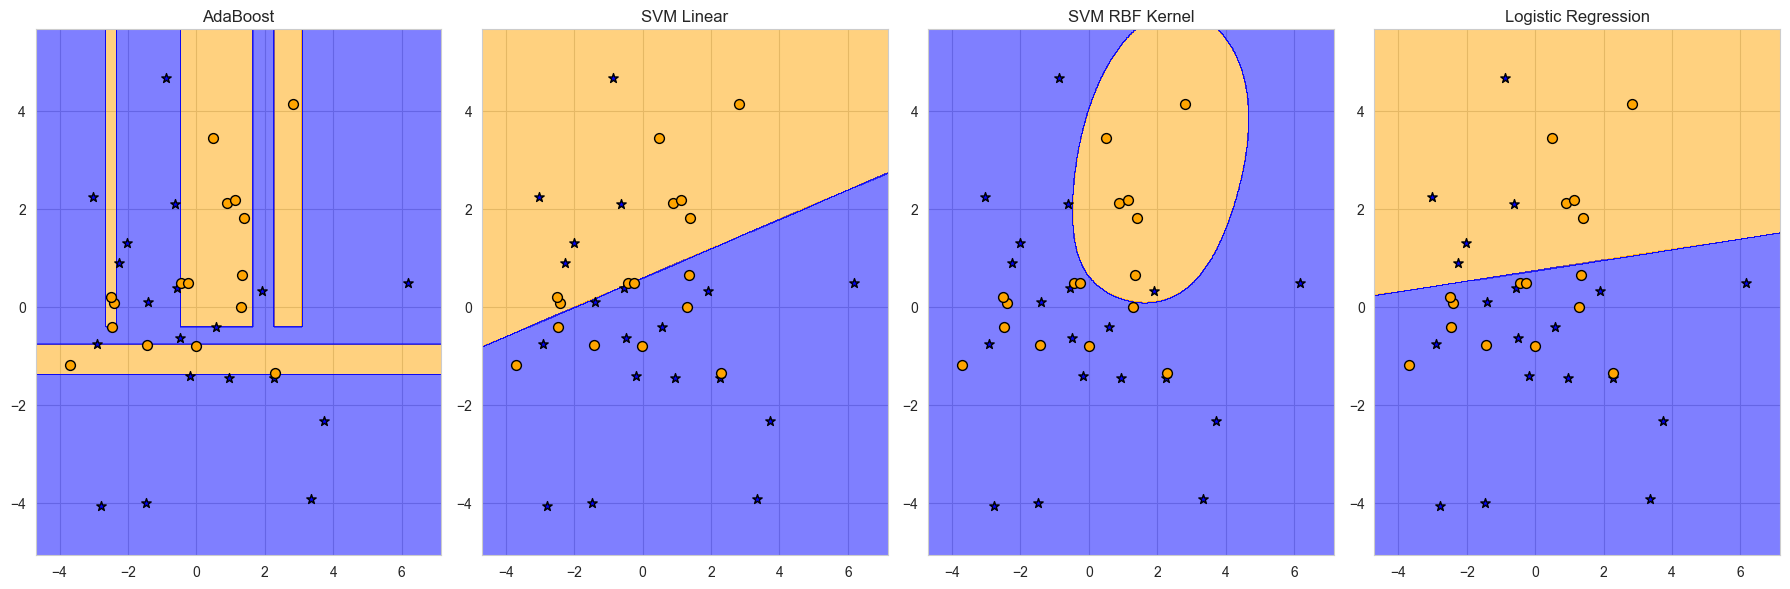

In [25]:
# Adaboost和Logistic回归、SVM的的分类界面区别
fig_1,ax_1 = plt.subplots(1,4,figsize = (18,6))
draw_decision_boundary(x_train,y_train,ada_2,ax_1[0],'AdaBoost')
draw_decision_boundary(x_train,y_train,svm_2,ax_1[1],'SVM Linear')
draw_decision_boundary(x_train,y_train,svm_k,ax_1[2],'SVM RBF Kernel')
draw_decision_boundary(x_train,y_train,log_2,ax_1[3],'Logistic Regression')
plt.tight_layout()
plt.show()
